# USS assets 
## historic growth 1992-2021 
## forecast growth from discount rates 2011, 14, 17, 20 and 21

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_base = '../data/'
path_assets = path_base + 'assets_returns/'
path_cpi = path_base + 'cpi_gilts/'
path_discount = path_base + 'discount_rates/'
path_ons = path_base + 'ons/'
path_best_est = path_base + 'best_estimates/'

BASE_YEAR=2020

### Load data

In [3]:
# Historic CPI, from ONS
cpi_ons = np.genfromtxt(path_ons + 'cpi_ons_derived_for_graph_ussbriefs106.csv', delimiter=',', usecols=(0,3), skip_header=1)

# Historic USS assets and investment growth
assets_nom = np.genfromtxt(path_assets + 'nominal/1992_2021_assets_nominal.csv', delimiter=',', usecols=(0,1), skip_header=1, dtype=float)
inv_ret_nom = np.genfromtxt(path_assets + 'nominal/1987_2021_investment_returns_nominal.csv', delimiter=',', usecols=(0,1), skip_header=1, dtype=float)

In [4]:
# Future prudent discount rates, assume column 0 is year, column 1 is term, column 2 is discount rate
# Should really compute from term to be derived more directly from data?
# Should really load from original data in nominal, and compute from USS projected CPI?
disc_prud_2011_cpi = np.genfromtxt(path_discount + 'cpi/2011_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2014_cpi = np.genfromtxt(path_discount + 'cpi/2014_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2017a_cpi = np.genfromtxt(path_discount + 'cpi/2017_September_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2017b_cpi = np.genfromtxt(path_discount + 'cpi/2017_November_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2018_cpi = np.genfromtxt(path_discount + 'cpi/2018_DISCOUNT_RATE_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2019_cpi = np.genfromtxt(path_discount + 'cpi/2019_DISCOUNT_RATE_interim_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2020a_cpi = np.genfromtxt(path_discount + 'cpi/2020_DISCOUNT_RATE_maintain_benefits_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2020b_cpi = np.genfromtxt(path_discount + 'cpi/2020_DISCOUNT_RATE_UUK_cuts_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2021a_cpi = np.genfromtxt(path_discount + 'cpi/2021_DISCOUNT_RATE_USS_est_maintain_benefits_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)
disc_prud_2021b_cpi = np.genfromtxt(path_discount + 'cpi/2021_DISCOUNT_RATE_USS_est_UUK_cuts_cpi_basis.csv', delimiter=',', usecols=(0,2), skip_header=1)

# Put prudent discount rates in a python doctionary for easy access
disc_prud_cpi_dict = { "2011" : disc_prud_2011_cpi,
                "2014" : disc_prud_2014_cpi,
                "2017a" : disc_prud_2017a_cpi,
                "2017b" : disc_prud_2017b_cpi,
                "2018" : disc_prud_2018_cpi,
                "2019" : disc_prud_2019_cpi,
                "2020a" : disc_prud_2020a_cpi,
                "2020b" : disc_prud_2020b_cpi,
                "2021a" : disc_prud_2021a_cpi,
                "2021b" : disc_prud_2021b_cpi}

### General helper functions

In [5]:
def log_interp(z, x, y):
    # Log interpolator - useful for asset values, or other quantities which grow exponentially
    logy = np.log10(y)
    return np.power(10.0, np.interp(z, x, logy, left=np.nan, right=np.nan))

### CPI helper functions

In [6]:
def cum_cpi_ons(base_yr=BASE_YEAR):
    """
    Calculates cumulative CPI index from ONS data, relative to a base year, 
    which defaults to the value specified above in BASE_YEAR
    
    Returns an array of two columns, year and value.
    """
    base_yr_ind = np.where(cpi_ons[:, 0] == base_yr)[0][0]
    cum_cpi = cpi_ons.copy()
    cum_cpi[base_yr_ind,1] = 1.0
    cum_cpi[base_yr_ind+1:, 1] = np.cumprod(1 + cpi_ons[base_yr_ind:-1, 1])
    cum_cpi[base_yr_ind-1::-1, 1] = np.cumprod(1/(1 + cpi_ons[base_yr_ind:0:-1, 1]))

    return cum_cpi

def get_cpi_ons(y):
    """
    Returns ONS CPI in year y, by linear interpolation.
    y can be single number, array, or range.
    
    Returns values with the same shape as y. 
    Years outside the ONS data return a nan.
    """
    return np.interp(y, cpi_ons[:,0], cpi_ons[:,1], left=np.nan, right=np.nan)

def get_cum_cpi_ons(y, base_year=BASE_YEAR):
    """
    Gets ONS cumulative CPI in year y relative to base_year. Fractions of year by geometric interpolation,. 
    y can be single number, array, or range.
    
    Returns values with the same shape as y. 
    Years outside the ONS data return a nan.
    """
    cpi_adj_arr = cum_cpi_ons(base_year)
    return log_interp(y, cpi_adj_arr[:, 0], cpi_adj_arr[:, 1])

## Discount rate helper functions

In [7]:
def cum_disc_uss_cpi(valuation, disc_dict=disc_prud_cpi_dict):
    """
    Calculates cumulative discounts forward from a given valuation date, 
    using USS data.
    Allowed values for valuation = "2011", "2014", "2017a", "2017b" 
    "2018", "2019", "2020a", "2020b", "2021a", "2021b"
        
    Returns an array of two columns, year and value.
    """
    disc = disc_dict[valuation]
    cum_disc = disc.copy()
    cum_disc[:, 1] = np.cumprod(1/(1 + disc[:, 1]))
    return cum_disc

def get_cum_disc_uss_cpi(y, valuation, disc_dict=disc_prud_cpi_dict):
    """
    Get USS cumulative discounts in year y, by geometric interpolation, relative to year of valuation.
    y can be single number, array, or range.
    
    Returns values with the same shape as y. 
    Years outside the ONS data return a nan.
    """
    disc_arr = cum_disc_uss_cpi(valuation, disc_dict)
    return log_interp(y, disc_arr[:, 0], disc_arr[:, 1])


## Assets and investment return helper functions

In [8]:
# Transform investment returns from nominal to CPI
inv_ret_cpi = inv_ret_nom.copy()
inv_ret_cpi[:,1] = inv_ret_nom[:, 1] - get_cpi_ons(inv_ret_nom[:, 0])

def cum_inv_ret_cpi(base_yr=BASE_YEAR):
    """
    Calculate cumulative investment returns, from CPI-adjusted  
    nominal investment returns.
    
    Returns an array of two columns, year and value.
    """
    base_yr_ind = np.where(inv_ret_cpi[:, 0] == base_yr)[0][0]
    cum_inv_ret_cpi = inv_ret_cpi.copy()
    cum_inv_ret_cpi[base_yr_ind,1] = 1.0
    cum_inv_ret_cpi[base_yr_ind+1:, 1] = np.cumprod(1 + inv_ret_cpi[base_yr_ind+1:, 1])
    cum_inv_ret_cpi[base_yr_ind-1::-1, 1] = np.cumprod(1/(1 + inv_ret_cpi[base_yr_ind:0:-1, 1]))

    return cum_inv_ret_cpi

def get_cum_inv_ret_cpi(y, base_yr=BASE_YEAR):
    """
    Get cumulatuve investment returns for any set of years y, with linear interpolation 
    for fractional years.
    
    Returns values with the same shape as y. 
    Years outside the ONS CPI data return a nan.
    """
    cum_inv_ret_arr = cum_inv_ret_cpi(base_yr)
    return log_interp(y, cum_inv_ret_arr[:, 0], cum_inv_ret_arr[:, 1])

def get_assets_cpi_reported(y, base_year=BASE_YEAR):
    """
    Get value of assets reported in USS annual statements for set of years y.
    
    Returns a two-column array of years y and values.
    """
    if hasattr(y, '__iter__'):
        len_y = len(y)
    else:
        len_y = 1
    assets_cpi = np.ones((len_y, 2))
    assets_cpi[:,0] = y
    assets_cpi[:,1] = np.interp(y, assets_nom[:, 0], assets_nom[:, 1]) / get_cum_cpi_ons(y, base_year)    
    return assets_cpi

def get_assets_cpi_inv_ret(y, base_year=BASE_YEAR):
    """
    Get value of assets calculated from investment returns in USS annual statements, 
    for set of years y.
    
    Returns a two-column array of years y and values
    """
    if hasattr(y, '__iter__'):
        len_y = len(y)
    else:
        len_y = 1
    assets_base = get_assets_cpi_reported(base_year)[0][1]
    assets_cpi = np.ones((len_y, 2))
    assets_cpi[:,0] = y
    assets_cpi[:,1] = assets_base * get_cum_inv_ret_cpi(y, base_year)
    return assets_cpi


In [9]:
# Construct estimates of investment assets
assets_cpi_2020 = get_assets_cpi_reported(assets_nom[:,0])
assets_cpi_inv_ret_2020 = get_assets_cpi_inv_ret(assets_nom[:,0])

In [10]:
# Assemble dictionary of projected assets estimated from USS prudent discount rates
end_year = 2068
proj_assets_cpi_2020 = {}

proj_assets_cpi_2020["2011"] = get_assets_cpi_reported(2011)[0,1]/get_cum_disc_uss_cpi(range(2012, end_year), "2011")
proj_assets_cpi_2020["2014"] = get_assets_cpi_reported(2014)[0,1]/get_cum_disc_uss_cpi(range(2015, end_year), "2014")
proj_assets_cpi_2020["2017b"] = get_assets_cpi_reported(2017)[0,1]/get_cum_disc_uss_cpi(range(2018, end_year), "2017b")
proj_assets_cpi_2020["2018"] = get_assets_cpi_reported(2018)[0,1]/get_cum_disc_uss_cpi(range(2019, end_year), "2018")
proj_assets_cpi_2020["2020a"] = get_assets_cpi_reported(2020)[0,1]/get_cum_disc_uss_cpi(range(2021, end_year), "2020a")
proj_assets_cpi_2020["2021a"] = get_assets_cpi_reported(2021)[0,1]/get_cum_disc_uss_cpi(range(2022, end_year), "2021a")


## Plots
### Asset projections with prudent discount rates

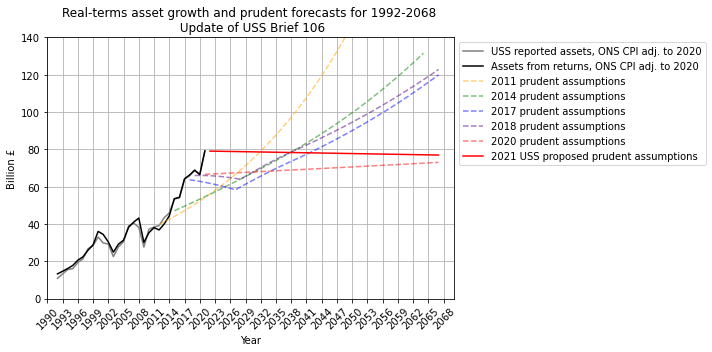

In [11]:
plt.figure(figsize=(10,5))

plt.plot(assets_cpi_2020[:,0], assets_cpi_2020[:,1], 
         color=(0.5,0.5,0.5), 
         label='USS reported assets, ONS CPI adj. to 2020')

plt.plot(assets_cpi_inv_ret_2020[:,0], assets_cpi_inv_ret_2020[:,1], 
         color='k', 
         label='Assets from returns, ONS CPI adj. to 2020')

plt.plot(range(2012, end_year), proj_assets_cpi_2020["2011"], 
         color='orange', ls='--', alpha=0.5, label='2011 prudent assumptions')
plt.plot(range(2015, end_year), proj_assets_cpi_2020["2014"], 
         color='green', ls='--', alpha=0.5, label='2014 prudent assumptions')
plt.plot(range(2018, end_year), proj_assets_cpi_2020["2017b"], 
         color='b', ls='--', alpha=0.5, label='2017 prudent assumptions')
plt.plot(range(2019, end_year), proj_assets_cpi_2020["2018"], 
         color='indigo', ls='--', alpha=0.5, label='2018 prudent assumptions')
plt.plot(range(2021, end_year), proj_assets_cpi_2020["2020a"], 
         color='red', ls='--', alpha=0.5, label='2020 prudent assumptions')
plt.plot(range(2022, end_year), proj_assets_cpi_2020["2021a"], 
         color='red', ls='-', alpha=1.0, label='2021 USS proposed prudent assumptions')

plt.xlim(1990,2070)
plt.ylim(0,140)

plt.title('Real-terms asset growth and prudent forecasts for 1992-2068 \n Update of USS Brief 106')
plt.xlabel('Year')
plt.ylabel('Billion £')

plt.xticks(np.arange(1990, 2070, 3.0))

plt.xticks(rotation= 45 )

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 0, .1, 1))

plt.tight_layout()
plt.savefig("uss_assets_and_prudent_forecasts.pdf")